# Project: Analyze Patient Data from Brazil

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

<p>This dataset contains information from over 100k medical appointments in Brazil. Using this data, I hope to determine what factors can predict whether or not a patient will show up for their scheduled appointment. I will ask the following questions:</p>
<ol>
    <li>Does the length of time before the appointment day affect whether or not the patient made their appointment?</li>
    <li>Does a text message update lead to less no-shows?</li>
    <li>Do pre-existing conditions affect no-shows?</li>
    <li>Does location show any correlation with missed appointments?</li>
</ol>

In [1]:
# Import Statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### General Properties

<p>First, I will inspect the data set to determine the degree of clean-up/wrangling I will have to do to make the data usable.
</p>

In [2]:
df = pd.read_csv('noshows.csv')
df.head(5) 

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


<p>It seems from the first few data points that some column headings are mispelled. To further inspect the data, I will perform a few more operations to determine the datatypes and cell counts. </p>

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


<p>It seems that every column contains non-null data values. I will just need to convert the dates to datetime data type to make analysis easier. The columns titled PatientId and AppointmentId also will not be useful for this analysis so I will remove these as well. Clean up should be relatively straight-forward for this data set.</p>

### Data Cleaning (Replace this with more specific notes!)

In [4]:
#Remove id and appointment columns
df.drop(['PatientId', 'AppointmentID'], axis=1, inplace=True)

#Change Column Headings
df.columns = ['gender', 'scheduled_day', 'appointment_day', 'age', 'neighborhood',
             'scholarship', 'hypertension', 'diabetes', 'alcoholism', 'handicap','sms_received','no_show']

#Change Data Type to Datetime
df['scheduled_day'] = pd.to_datetime(df['scheduled_day']);
df['appointment_day'] = pd.to_datetime(df['appointment_day']);

#Change Yes and No to Binary
df.loc[df['no_show']=='Yes', 'no_show'] = 1
df.loc[df['no_show']=='No', 'no_show'] =0

<p>Now that the data is cleaner, I can print some descriptive statistics to get more info from the dataset</p>

In [5]:
df.describe()

,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,0.201933
std,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,0.401444
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000


<p>I noticed that the minimum age is negative, so I will filter the data to drop the values that are malformed.</p>

In [6]:
df.drop(df.query('age < 0').index,inplace=True);
df.describe()['age']

count    110526.000000
mean         37.089219
std          23.110026
min           0.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: age, dtype: float64

<p>The age column looks much cleaner now, and it looks like it was only one entry that needed to be dropped. Therefore, we can assume that the statistics and trends we compute will still hold their fidelity</p>

<a id='eda'></a>
## Exploratory Data Analysis

### Does the length of time before the appointment day affect whether or not the patient made their appointment?

In [7]:
#Determine Time Between Schedule Date and the Appointment Date
time_elapsed = (df['appointment_day'] - df['scheduled_day']).dt.days;
df['time_elapsed'] = time_elapsed
df.describe()

,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,time_elapsed
count,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000
mean,37.089219,0.098266,0.197248,0.071865,0.030400,0.022248,0.321029,0.201934,9.183794
std,23.110026,0.297676,0.397923,0.258266,0.171686,0.161543,0.466874,0.401445,15.255034
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,14.000000
max,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,178.000000


<p>These sample statistics show that the elapsed time is negative in some cases, which would mean the data is malformed in these instances. Since this occurs in about 25% of a 110k dataset, we can drop these values without losing fidelity of our analysis.</p>

In [8]:
#Drop Malformed Data
df.drop(df[time_elapsed < 0].index,inplace=True);

#Get Quartiles
df.describe()

,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,time_elapsed
count,71959.000000,71959.000000,71959.000000,71959.000000,71959.000000,71959.000000,71959.000000,71959.000000,71959.000000
mean,38.502564,0.092706,0.208897,0.074723,0.025320,0.020025,0.493086,0.285190,14.642018
std,22.925421,0.290021,0.406523,0.262946,0.157096,0.154072,0.499956,0.451508,16.494334
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
50%,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000
75%,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,21.000000
max,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,178.000000


<p>I will first create a histogram of the time elapsed column to determine how far in advanced most people book trips</p>

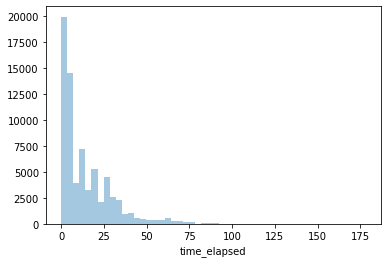

In [9]:
#Plot Histogram
fig,ax = plt.subplots();
sns.distplot(df['time_elapsed'], ax=ax,kde=False);

<p>I also want to use a box plot to clearly see the number of outliers this data may have</p>

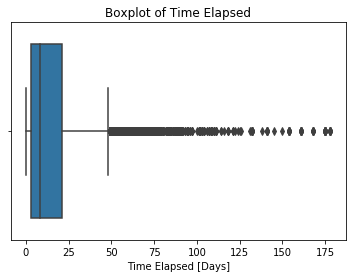

In [10]:
#Create Box Plot
fig,ax = plt.subplots();
sns.boxplot(x=df['time_elapsed']);
plt.title('Boxplot of Time Elapsed');
plt.xlabel('Time Elapsed [Days]');

<p>We can see that there are a good number of outliers over 50, so I will filter the data so these values are not included in the calculations. I don't want to lose these values for future calculations, however, so I will clone the dataframe. </p>

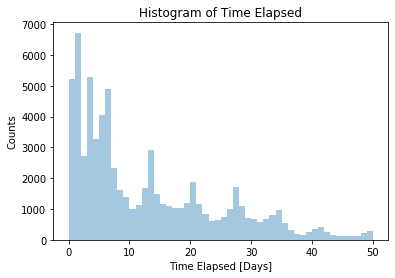

In [11]:
#Clone Data Frame
df_clone = df.copy();

#Filter outliers
df_clone.drop(df.query('time_elapsed > 50').index,inplace=True);

#Plot histogram again
fig,ax = plt.subplots();
sns.distplot(df_clone['time_elapsed'], ax=ax,kde=False);
plt.title('Histogram of Time Elapsed');
plt.ylabel('Counts');
plt.xlabel('Time Elapsed [Days]');

<p>The data looks much better now, so we can start to make some further examinations of the trends. </p>

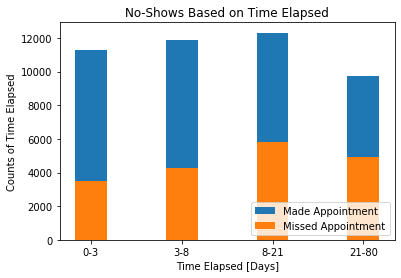

In [12]:
#Formulate Stacked Bar Chart to Show Relationship Between Time Elapsed and No-Show
bins = pd.cut(df_clone['time_elapsed'],[0, 3, 8, 21, 50])
df_time = df_clone.groupby(['no_show',bins])['time_elapsed'].agg(['count'])
width = 0.35

p1 = plt.bar(['0-3','3-8','8-21','21-80'],df_time['count'][:4], width);
p2 = plt.bar(['0-3','3-8','8-21','21-80'],df_time['count'][4:], width);
plt.title('No-Shows Based on Time Elapsed');
plt.ylabel('Counts of Time Elapsed');
plt.xlabel('Time Elapsed [Days]');
plt.legend((p1[0],p2[0]),('Made Appointment', 'Missed Appointment'),loc=4);

<p>The graph shows that the closer to the appointment that people schedule, the more likely they are to make the appointment. If they book it in advanced (>8 days), it is more likely they will miss the appointment.</p>

### Does a text message update lead to less no-shows?

In [13]:
#Prepare the data for analysis
sms_counts = df.groupby('sms_received').describe()['no_show']['count']
sms_shows = df.groupby('sms_received').describe()['no_show']['mean']

<p>Now that the code is prepared for analysis. I will assign it to a bar chart using Matplotlib.</p>

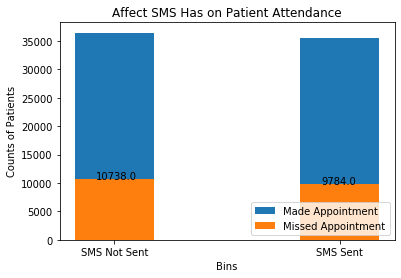

In [14]:
#Plot the data in a bar chart
ind = np.arange(2)
p1 = plt.bar(ind, sms_counts, width);
p2 = plt.bar(ind, sms_shows*sms_counts, width);
plt.xticks(ind, ['SMS Not Sent', 'SMS Sent']);

plt.ylabel('Counts of Patients');
plt.xlabel('Bins');
plt.title('Affect SMS Has on Patient Attendance')
plt.legend((p1[0],p2[0]),('Made Appointment', 'Missed Appointment'),loc=4);
for i, v in enumerate(sms_counts*sms_shows):
    plt.text(ind[i]-0.08, v, str(v))
plt.show()

<p>As the plot above shows, SMS hardly had an impact on whether or not a person missed their appointment. There could be other factors going on that may have an impact, however, they are not explored in this visualization. 

### Do pre-existing conditions affect no-shows?

In [15]:
#Prepare Data for Analysis
pre_existing = df.groupby('no_show').describe()
pre_existing = pre_existing.loc[:,['hypertension','diabetes','alcoholism', 'handicap']]

#Parse Means from List
mean_ht = pre_existing['hypertension']['mean']
mean_d = pre_existing['diabetes']['mean']
mean_a = pre_existing['alcoholism']['mean']
mean_hc = pre_existing['handicap']['mean']
remaining = [1,1] - mean_ht - mean_d - mean_a - mean_hc


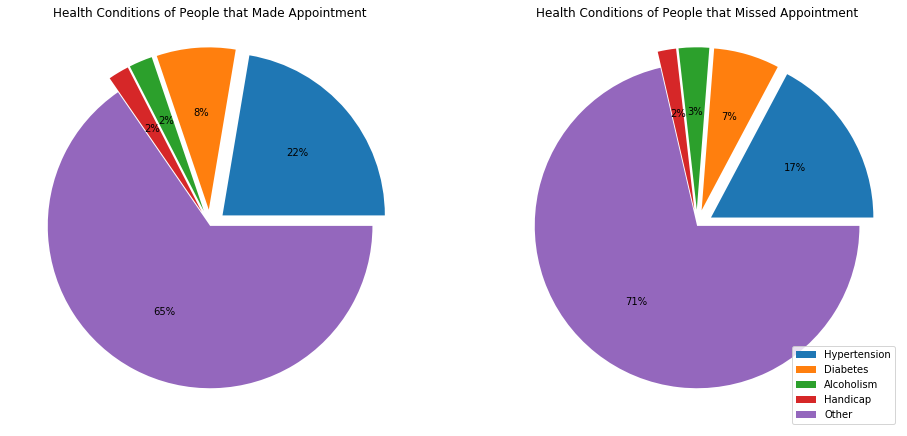

In [16]:
#Plot of people who made their appointment
fig1, ax = plt.subplots(nrows=1,ncols=2, figsize=[16,8])

ax[0].title.set_text('Health Conditions of People that Made Appointment')
p1 = ax[0].pie([mean_ht[0], mean_d[0], mean_a[0], mean_hc[0], remaining[0]], 
            explode = (0.1,0.1,0.1,0.1,0),autopct='%1.0f%%')

#Plot of people who missed appointment
ax[1].title.set_text('Health Conditions of People that Missed Appointment')
p2 = ax[1].pie([mean_ht[1], mean_d[1], mean_a[1], mean_hc[1], remaining[1]], 
            explode = (0.1,0.1,0.1,0.1,0), autopct='%1.0f%%')
ax[1].legend(labels=['Hypertension', 'Diabetes', 'Alcoholism', 'Handicap', 'Other'],loc=4);

<p>It appears that those with hypertension are more likely to not miss their appointment, then those with any other pre-existing condition. However, it must be stated again that this type of statistic is limited in its scope so further investigation would be necessary.</p>

## <a id='conclusions'></a>
## Conclusions

<p>Using these analyses, we saw that the average number of no shows decreased when people made shorter term appointments. We also saw that SMS messages hardly made a difference by itself in who showed up for their appointment. Finally, we explored how pre-existing conditions could affect appointment attendance. We noticed that there were a higher percentage of those with hypertension attending their appointment as well. 

Performing a correlation test on the dataframe, we can extract even more information and determine what questions were valuable.</p>

In [17]:
df.corr()

,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,time_elapsed
age,1.000000,-0.103038,0.500749,0.284477,0.080350,0.077141,-0.042537,-0.101042,-0.008608
scholarship,-0.103038,1.000000,-0.027764,-0.025417,0.030529,-0.010446,0.020666,0.045687,-0.026177
hypertension,0.500749,-0.027764,1.000000,0.425614,0.085821,0.083643,-0.037065,-0.056859,-0.051121
diabetes,0.284477,-0.025417,0.425614,1.000000,0.024174,0.061513,-0.031219,-0.022412,-0.048246
alcoholism,0.080350,0.030529,0.085821,0.024174,1.000000,0.013501,-0.009095,0.019864,-0.029137
handicap,0.077141,-0.010446,0.083643,0.061513,0.013501,1.000000,-0.022107,-0.007184,-0.015865
sms_received,-0.042537,0.020666,-0.037065,-0.031219,-0.009095,-0.022107,1.000000,-0.020631,0.201789
no_show,-0.101042,0.045687,-0.056859,-0.022412,0.019864,-0.007184,-0.020631,1.000000,0.060362
time_elapsed,-0.008608,-0.026177,-0.051121,-0.048246,-0.029137,-0.015865,0.201789,0.060362,1.000000


<p>From this test, we can see that things like age are associated with diabetes and hypertension. In terms of our questions, we can see that our findings that hypertension is more correlated than the other conditions is true. We can also see that text messages have nearly 0 correlation with attendance. Doing tests like this ground our research and show us what questions actually have an impact on what we are trying to solve.</p>

<p>Finally, this data set was very limited in its scope. Due to malformed age and scheduling data, I had to cut out a large portion of the data set. This reduction in data points makes the data less scalable and less representative of the entire population.

It would have also been useful if time data was collected for the AppointmentDay so that more studies could have been conducted on the impact that the time of day may have.</p>